In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from fbprophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')




In [2]:
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Test.csv")

In [3]:
train_data["data"]="train"
test_data["data"]="test"
data=pd.concat([train_data,test_data])
data = data.reset_index().drop(columns="index")

In [4]:
data.columns

Index(['ID', 'Datetime', 'Count', 'data'], dtype='object')

In [15]:
def Fbprophet(data):
    size = np.sum(data['data']=='train')
    train_data = data[data["data"]=="train"]
    inter_df = train_data[['ds','y']]
    m = Prophet(weekly_seasonality='auto', daily_seasonality='auto',seasonality_mode='multiplicative')
    m.fit(inter_df)
    y_train=m.predict(train_data[['ds']])
    y_train_pred = y_train['yhat']
    print("RMSE : ",np.sqrt(mean_squared_error(train_data['y'],y_train_pred)))
    test_data = data[data["data"]=="test"]
    print(test_data.columns)
    forecast = m.predict(test_data[['ds']])
    fcst = forecast['yhat']
    plt.plot(train_data.index, train_data.y)
    plt.plot(test_data.index, forecast["yhat"])
    print(type(fcst))
    test_data = test_data.reset_index().drop(columns="index")
    df_fcst=fcst.to_frame()
    print(df_fcst.columns)
    print("test_data df",df_fcst["yhat"])   
    submit = pd.concat([test_data[["ID"]], df_fcst],  axis = 1)
    print(submit)
    return submit


RMSE :  77.18024739454417
Index(['ID', 'ds', 'data', 'y'], dtype='object')
<class 'pandas.core.series.Series'>
Index(['yhat'], dtype='object')
test_data df 0       213.633570
1       185.431529
2       157.209390
3       135.271934
4       121.126545
           ...    
5107    607.443958
5108    588.494735
5109    572.558443
5110    553.301725
5111    510.159014
Name: yhat, Length: 5112, dtype: float64
         ID        yhat
0     18288  213.633570
1     18289  185.431529
2     18290  157.209390
3     18291  135.271934
4     18292  121.126545
...     ...         ...
5107  23395  607.443958
5108  23396  588.494735
5109  23397  572.558443
5110  23398  553.301725
5111  23399  510.159014

[5112 rows x 2 columns]


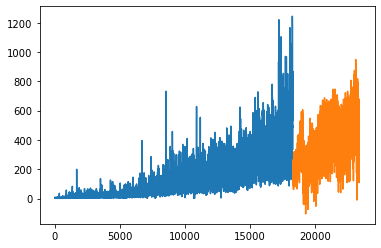

In [16]:
required_cols = [col for col in data.columns if col not in ['ID','Datetime', 'data']]


Result=pd.DataFrame()

for model in [Fbprophet]:
    for i in required_cols:
        data['Datetime'] = pd.to_datetime(data['Datetime'])
        to_func = data[['ID', 'Datetime',  'data', i]]
        to_func.columns=['ID', 'Datetime', 'data', 'Count']
        if model == Fbprophet:
            to_func.columns=["ID","ds","data", "y"]
            Result_inter = model(to_func[['ID','ds','data', 'y']])
            Result_inter.name = model.__name__ + "_" +  i
            Result_inter.index = range(len(Result_inter))
            
Result_inter.to_csv('Forecast_fbProphet.csv')